In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

[Presentation Link](https://docs.google.com/a/frederickcheung.com/presentation/d/1-FGwFy3TOuqVNx2sdz7KIA5VIMpaFBABDaXnBWEYjH8/edit?usp=sharing)

# Due Diligence

Limitations to working with my data, 40k+ dimensions, it is not enough to say that there were 4 groups.

In [19]:
data1 = pd.read_table('menuitems.normalized', " [+] ", engine = 'python', header = None)
data2 = data1.drop(5, axis=1)
data2[4] = data2[4].astype(str)
data2 = data2.groupby([0,3])[4].apply(lambda x: ' '.join(x)).reset_index()
data2.head(1)

,0,3,4
0,#1 Chop Suey,$,pork noodle soup large ham small extra onion h...


In [20]:
#data frame with name and price rating of restaurant
data3 = data2.drop(4, axis = 1)
data3.columns = ['name','price']
data3.head(1)

,name,price
0,#1 Chop Suey,$


In [21]:
#data frame with Name and all Menu items
data4 = data2.drop(3, axis=1)
data4.columns = ['name','menu']
data4.head(1)

,name,menu
0,#1 Chop Suey,pork noodle soup large ham small extra onion h...


In [24]:
# Calculate TFIDF 
data_dict = data4 #.drop([1,2,3], axis=1)
data_dict.head()
data_dict2 = data_dict.set_index('name')['menu'].to_dict()

#TFIDF calculation resulting in sparse matrix
v = TfidfVectorizer(stop_words = 'english')
sparse_df = v.fit_transform(data_dict2.values())

#convert sparse matrix to dense matrix
dense_df1 = pd.DataFrame(sparse_df.toarray())


### Take a 10% sample of the Data

In [27]:
#concat full TF-IDF df with Pricing df
kmeans_df = pd.concat([dense_df1, data3], axis=1)

#convert categorial to numeric
kmeans_df2 = kmeans_df.dropna()
kmeans_df2.loc[kmeans_df2.iloc[:,-1] == '$','price'] = 1
kmeans_df2.loc[kmeans_df2.iloc[:,-1] == '$$','price'] = 2
kmeans_df2.loc[kmeans_df2.iloc[:,-1] == '$$$','price'] = 3
kmeans_df2.loc[kmeans_df2.iloc[:,-1] == '$$$$','price'] = 4

#take 10% sample of each sub sample and concatenate
sample_price1 = kmeans_df2.query("price == 1").sample(frac=.1)
sample_price2 = kmeans_df2.query("price == 2").sample(frac=.1)
sample_price3 = kmeans_df2.query("price == 3").sample(frac=.1)
sample_price4 = kmeans_df2.query("price == 4").sample(frac=.1)

#once concatenated, remove vectors that are not part of the numerical array
frames = [sample_price1,sample_price2,sample_price3,sample_price4]
kmeans_sample = pd.concat(frames)
kmeans_sample2 = kmeans_sample.drop(['name','price'], axis=1)

kmeans_sample2.head(1)

,0,1,2,3,4,5,6,7,8,9,...,47633,47634,47635,47636,47637,47638,47639,47640,47641,47642
3981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the Centroids

In [11]:
#define function to return the centroid array
from sklearn.cluster import KMeans
def find_kmeans_centroids(num):
    kmeans_results = KMeans(n_clusters=num, random_state=0).fit(kmeans_sample2.values)
    A = kmeans_results.cluster_centers_
    return A

In [30]:
#vary the number of centroids to ensure I have right number of groups
kmeans_results3 = find_kmeans_centroids(3)
kmeans_results4 = find_kmeans_centroids(4)
kmeans_results5 = find_kmeans_centroids(5)
kmeans_results6 = find_kmeans_centroids(6)

### Projecting 40k+ features to 3D

In [49]:
from sklearn.decomposition import PCA

A = kmeans_results6 #change this variable based on how many centroids

#Note: I projecting all 40k+ features onto only 3 dimensions
PCA_object = PCA(n_components=3)
PCA_object2 = pd.DataFrame(PCA_object.fit(A).transform(A), columns = ['x', 'y', 'z'])
PCA_object2['cluster'] = PCA_object2.index #index as category for color coding

### Graphical Justification
Graphical intuition to give us an idea of the data based on plots based on 3 dimensions

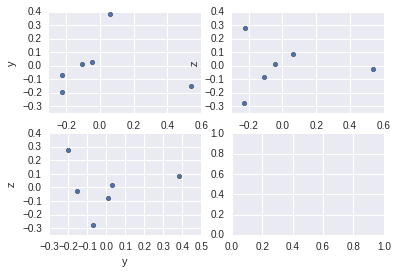

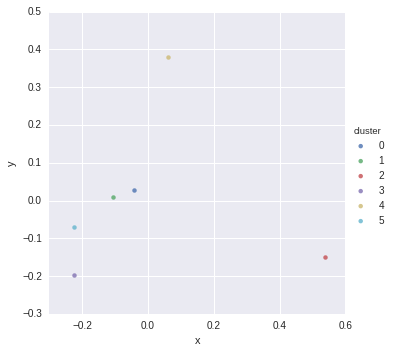

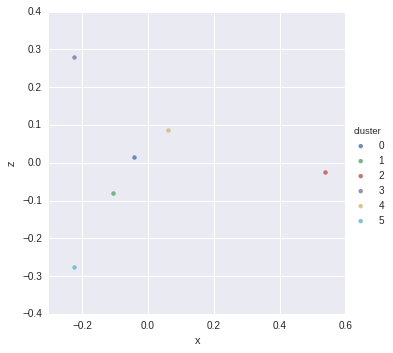

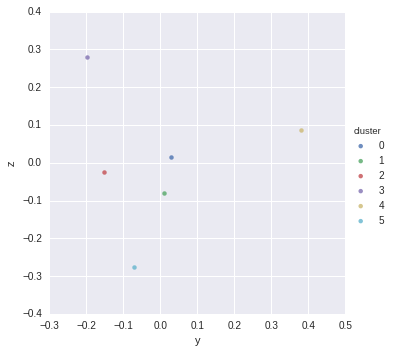

In [50]:
fig,ax = plt.subplots(2,2)
PCA_object2.plot('x', 'y', kind='scatter', ylim=(-.35,.4), ax=ax[0,0])
PCA_object2.plot('x', 'z', kind='scatter', ylim=(-.35,.4), ax=ax[0,1])
PCA_object2.plot('y', 'z', kind='scatter', ylim=(-.35,.4), ax=ax[1,0])

# sns.FacetGrid

sns.lmplot('x','y',data=PCA_object2, hue='cluster', fit_reg=False)
sns.lmplot('x','z',data=PCA_object2, hue='cluster', fit_reg=False)
sns.lmplot('y','z',data=PCA_object2, hue='cluster', fit_reg=False)

In [51]:
#cannot use FacetGrid to plot, needs to be in long format, how to do this with different dimensions?
# g = sns.FacetGrid(PCA_object2, col=('z'), hue='cluster')
# g.map_dataframe(plt.scatter, 'x', 'y')

### Numerical Justification
Using the Euclidean distance to determine the distance beween centroids

In [16]:
#define function to return the euclidean distance
def euclid_dist(num):
    var1 = find_kmeans_centroids(num)
    var2 = []
    for i in range(num):
        for j in range (i+1, num):
            var2.append((i,j, np.sqrt(np.sum(var1[i,:]-var1[j,:])**2)))
    return var2

In [17]:
#vary the number of centroids to ensure I have right number of groups
# ans3 = euclid_dist(3)
ans4 = euclid_dist(4)
# ans5 = euclid_dist(5)
# ans6 = euclid_dist(6)

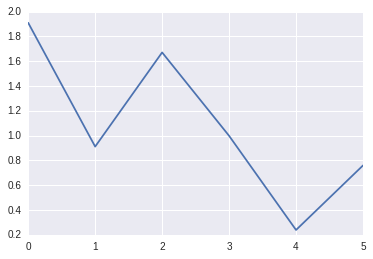

In [41]:
#Graphical representation of 
plt.plot(map(lambda x:x[2],ans4))